# Continued Development

## Purpose

This notebook is intended to provide a continuation on
the project thus far. Rather than deleting or
overwriting sections in the first two notebooks, this
notebook is to act as a way to cover "Next Steps" as
outlined at the end of the second notebook.

Because this notebook exists outside of the scope of
the original project, this notebook may be messier and
won't provide as much extensive detail.

Once this discovery reaches a satisfactory point, the
project will undergo the same restructuring that was
taken during its creation, including a recreation of
the README and presentation.

## Imports

Because work has been done to clean data that exists as
a jumping-off point, this notebook won't recreate the
initial data - though it is important to note that
newer and more accurate data will become available over
time and this may not immediately be taken into account
during the processes outlined within.

In [1]:
import numpy as np
import polars as pl
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, \
            GradientBoostingRegressor
from sklearn.model_selection import train_test_split, \
            cross_val_score, GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer

from joblib import parallel_backend, Parallel, \
            dump, load

from _code.cleaner import preprocess

from IPython.display import Image, Markdown

%matplotlib inline

## Recreating Processes

Many of the processes used in 2_Modeling.ipynb are
still valid that lead up to the actual model process,
so these steps will be combined here without explicit
explanation.

### Data importing

In [2]:
# import initial card data set
cards = pd.read_parquet('./data/simplified_cards.parquet')

### Pre-processing

In [3]:
# perform pre-processing of abilities
processed_abilities = preprocess(cards['oracle_text'])
cards['abilities_list'] = [
    abilities.split('\n') 
    for abilities in processed_abilities
    ]

# create an ability count feature
cards['n_abilities'] = cards['abilities_list'].map(len)

### Train-Test-Split

In [4]:
# create train and test sets that are divided based on
# the set that a card is a part of 
X = cards.drop(columns=['prices_normal','prices_foil'])
y = cards['set']
train, test, _, _ = \
    train_test_split(
        X,y,stratify=y,
        random_state=13,
        test_size=0.2
    )

# we'll reset the indices of both sets to more easily
# translate between polars and pandas in an upcoming
# step

train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

### Vectorization Process

#### Vectorize Abilities

In [5]:
# Our token pattern needs to be able to account for
# several non-standard things for it to be effective
# for our needs. As normal, it needs to be able to
# match words that are contiguous letters of an
# arbitrary length. However, we also need to be able to
# account for numbers in a few formats. These can be
# wrapped in curly brackets, e.g. {2}, representing 2
# colorless mana.
# It also needs to be able to account for letters
# inside of curly brackets and return them as such.
# It must also match something like +1/+1, -1/-1, or
# several other variations thereof.
# Lastly, it should also ignore any text that is inside
# of parentheses, as this text is reminder text - which
# is text that explains what an ability does but this
# text doesn't actually contribute to explaining what
# a card does in a meaningful way. 

token_pattern = \
    r"([a-zA-Z]+(?:’[a-z]+)?|[+-]?\d\/[+-]?\d|\{\d\d?\}|\{.\s?.?\}|\n)|\(.+?\)"

cvec = CountVectorizer(
        token_pattern=token_pattern,
        # min_df=0.0005, # <= this will mean that the
                    # minimum number of cards that it
                    # takes for an ability to show up
                    # on this list will be 46 after the
                    # explode is run, since it will be
                    # 83,000 entries long. We'll just
                    # limit our overall features since
                    # this is such a small percentage. 
        max_df=0.4,
        ngram_range=(1,5),
        max_features=1500
    )

# Exploding abilities to create a vectorized set
explode_train = train.explode('abilities_list')

explode_vec = cvec.fit_transform(
        explode_train['abilities_list']
    )
explode_vec = pd.DataFrame.sparse.from_spmatrix(
    explode_vec
)

# we save the vocab here to export for later. This is
# so we can bring in new data and make sure it's only
# being segmented into vocab we can "understand"
explode_vec.columns = sorted((vocab := cvec.vocabulary_))
explode_vec['id'] = explode_train['id'].values
explode_vec.head()

# convert pandas vectorized dataframe to polars
pl_vec = pl.from_pandas(explode_vec.astype(np.int32,errors='ignore'))
# perform group by and sum aggregation and convert back
# to pandas 
agged_vec = pl_vec.groupby('id').sum().to_pandas()

#### Vectorizing Types

In [6]:
card_type_cvec = CountVectorizer()

type_frame = pl.from_pandas(train['type_line']).apply(lambda x: x.split('—')[0])
type_df = pd.DataFrame.sparse.from_spmatrix(
    card_type_cvec.fit_transform(type_frame)
)
# we save the type vocab for later to export
type_df.columns = sorted((type_vocab:=card_type_cvec.vocabulary_))
type_df['id'] = train['id']

#### Vectorizing Color Identity

In [7]:
train['str_color_identity'] = \
    train['color_identity'].map(
        lambda x: ' '.join(x)
        )

color_match = CountVectorizer(
    token_pattern=r"[wubrg]"
)
color_id_df = pd.DataFrame.sparse.from_spmatrix(
    color_match.fit_transform(train['str_color_identity'])
)
color_id_df.columns = sorted(
        (color_vocab:=color_match.vocabulary_)
    )
color_id_df['c'] = color_id_df.T.apply(lambda x: 1 if sum(x)==0 else 0)
color_id_df['id'] = train['id']

#### Vectorizing Pseudo-Numbers et al

In [8]:
dummy_vectorizer = CountVectorizer(
    token_pattern = r".*",
    stop_words=[''],
    lowercase=False
    )
dummy_dict = {}
dummy_vocab = {}
dummy_columns = ['rarity','power','toughness','loyalty']
for _col in dummy_columns:
    dummy_column = train[_col].T.apply(
        lambda x: '' if x == None else f'{_col}_{x}'
        )
    dummy_dict[_col] = pd.DataFrame.sparse.from_spmatrix(
        dummy_vectorizer.fit_transform(dummy_column)
    )
    dummy_vocab[_col] = dummy_vectorizer.vocabulary_
    dummy_dict[_col].columns = sorted(dummy_vocab[_col])
    dummy_dict[_col]['id'] = train['id']

dummies = train[['id']]
for _col in dummy_columns:
    dummies = dummies.merge(
        dummy_dict[_col],
        on='id'
    )

### Date-to-Age Conversion

In [9]:
_now = pd.Timestamp.today().floor('D')
train['card_age'] = train['released_at'].apply(lambda x: (_now - x).days)

### Feature Reduction

In [10]:
# purpose for each column is explained in notebook 2
# for simplicity, this won't be repeated here 
used_columns = [
    'id','cmc','promo','reprint','full_art','textless',
    'n_abilities','median_normal','median_foil','card_age'
]
train_reduced = train[used_columns].copy()

### Data Merging and Subsetting

In [11]:
train_combined = train_reduced.merge(
    agged_vec,
    on='id'
).merge(
    type_df,
    on='id'
).merge(
    color_id_df,
    on='id'
).merge(
    dummies,
    on='id'
)

train_combined = train_combined[
    (train_combined[ 'stickers' ] == 0) &
    (train_combined['conspiracy'] == 0)
].drop(columns=['stickers','conspiracy']).copy()

# creating a normal and foil subset
train_norm = train_combined.dropna(
    subset=['median_normal']
    ).drop(columns=['median_foil']
    ).reset_index(drop=True)

train_foil = train_combined.dropna(
    subset=['median_foil']
    ).drop(columns=['median_normal']
    ).reset_index(drop=True)

norm_prices = train_norm['median_normal']
foil_prices = train_foil['median_foil']

## Modeling (Again)

### Dummy Model

We'll recreate the dummy model here to have a baseline
for comparison later on.

In [12]:
dummy = DummyRegressor(strategy='median')
norm_guess = dummy.fit(
    train_norm,norm_prices
    ).predict(train_norm)
foil_guess = dummy.fit(
    train_foil,foil_prices
    ).predict(train_foil)

norm_base_rmse = mean_squared_error(
        norm_prices,norm_guess,
        squared=False
    )
foil_base_rmse = mean_squared_error(
        foil_prices,foil_guess,
        squared=False
    )

### Gradient Boost Searching

In [15]:
# gbr = {
#     'norm':GradientBoostingRegressor(
#         random_state=13,
#         verbose=3,
#         n_iter_no_change=5
#         ),
#     'foil':GradientBoostingRegressor(
#         random_state=13,
#         verbose=3,
#         n_iter_no_change=5
#         )
# }
# params = {
#     'learning_rate':[
#         1.0,
#         0.5,
#         # 0.25,
#         0.1,
#         # 0.01
#         ],
#     'n_estimators':[
#         50,
#         100,
#         # 200
#         ],
#     # 'subsample':[1.0],
#     'min_samples_split':[
#         # 5,
#         10,
#         20
#         ],
#     # 'min_samples_leaf'=1,
#     # 'min_weight_fraction_leaf'=0.0,
#     'max_depth':[
#         # 25,
#         50,
#         100,
#         200
#         ],
#     # 'max_features'=None,
#     # 'alpha'=0.9,
#     # 'max_leaf_nodes'=None,
# }

In [17]:
# X = train_norm.drop(columns=['median_normal','id']).to_numpy()
# y = train_norm['median_normal'].to_numpy()

# with parallel_backend('threading',n_jobs=10):
#     norm_gs = GridSearchCV(
#         gbr['norm'],params,
#         scoring='neg_root_mean_squared_error',
#         verbose=10
#     ).fit(
#         X,y
#     )

         4         237.3863           28.57m
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 2/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 3/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 4/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 5/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 1/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 2/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 3/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 4/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 5/5; 2/36] START learning_rate=1.0, max_depth=50, min_sam

In [18]:
# X = train_foil.drop(columns=['median_foil','id']).to_numpy()
# y = train_foil['median_foil'].to_numpy()

# with parallel_backend('threading',n_jobs=10):
#     foil_gs = GridSearchCV(
#         gbr['foil'],params,
#         scoring='neg_root_mean_squared_error',
#         verbose=10
#     ).fit(
#         X,y
#     )

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 2/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 3/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 4/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 5/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 1/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 2/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 3/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 4/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 5/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
      Iter   

In [14]:
GradientBoostingRegressor?

Init signature:
GradientBoostingRegressor(
    *,
    loss='squared_error',
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    init=None,
    random_state=None,
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0,
)
Docstring:     
Gradient Boosting for regression.

This estimator builds an additive model in a forward stage-wise fashion; it
allows for the optimization of arbitrary differentiable loss functions. In
each stage a regression tree is fit on the negative gradient of the given
loss function.

:class:`sklearn.ensemble.HistGradientBoostingRegressor` is a much faster
variant of this algorithm for intermediate datasets (`n_samples >= 10_000`).

Read more in the :ref:`Us

In [20]:
# dump(foil_gs,'./pickles/foil_gb.pkl')
# dump(norm_gs,'./pickles/norm_gb.pkl')

['./pickles/norm_gb.pkl']

In [ ]:
norm_gs = load('./pickles/norm_gb.pkl')
foil_gs = load('./pickles/foil_gb.pkl')

In [24]:
X = train_foil.drop(columns=['median_foil','id']).to_numpy()
y = train_foil['median_foil'].to_numpy()
print(mean_squared_error(foil_gs.predict(
        X
    ),y,squared=False))

X = train_norm.drop(columns=['median_normal','id']).to_numpy()
y = train_norm['median_normal'].to_numpy()
print(mean_squared_error(norm_gs.predict(
        X
    ),y,squared=False))

17.380695178665317
19.65957104881276


In [28]:
norm_diff = pd.DataFrame(
    {
        'true': train_norm['median_normal'].to_numpy(),
        'preds':norm_gs.predict(train_norm.drop(columns=['median_normal','id']).to_numpy())
    }
)
norm_diff['diff'] = abs(norm_diff['true'] - norm_diff['preds'])

In [54]:
foil_diff = pd.DataFrame(
    {
        'true': train_foil['median_foil'].to_numpy(),
        'preds':foil_gs.predict(train_foil.drop(columns=['median_foil','id']).to_numpy())
    }
)
foil_diff['diff'] = abs(foil_diff['true'] - foil_diff['preds'])

In [69]:
len(norm_diff[norm_diff['diff']<1])/len(norm_diff),\
len(foil_diff[foil_diff['diff']<1])/len(foil_diff),\
len(foil_diff[foil_diff['preds']<0])/len(foil_diff)

(0.8474606186294842, 0.8257083400032016, 0.06134144389306867)

In [71]:
foil_diff[foil_diff['preds']<0]['true'].sort_values()

11477      0.010
16535      0.010
24094      0.010
19885      0.010
12706      0.010
          ...   
15267     27.840
10184     30.000
17865     84.730
1595      92.100
9093     130.305
Name: true, Length: 1916, dtype: float64

11999.99


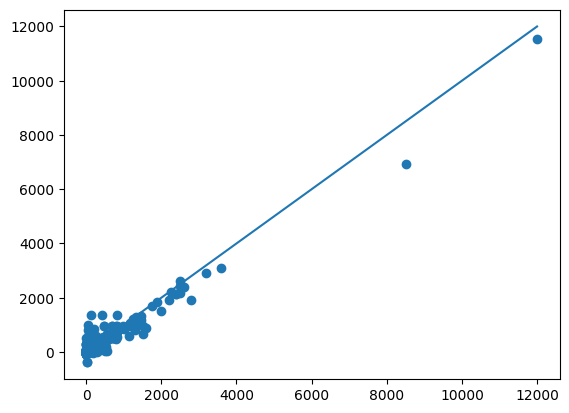

In [51]:
fig,ax = plt.subplots()
ax.scatter(norm_diff['true'],norm_diff['preds'])
_mx = max(norm_diff['true'])
print(_mx)
ax.plot((0,_mx),(0,_mx))
'';

3500.0


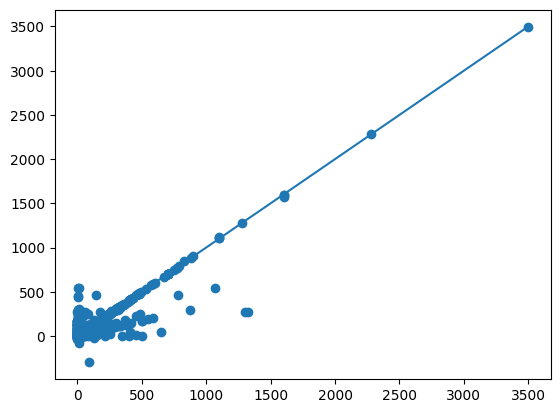

In [55]:
fig,ax = plt.subplots()
ax.scatter(foil_diff['true'],foil_diff['preds'])
_mx = max(foil_diff['true'])
print(_mx)
ax.plot((0,_mx),(0,_mx))
'';

#### Log Model

Much like before, foil prices are being predicted as
negative. We'll try running a log model for everything.

In [56]:
# X = train_norm.drop(columns=['median_normal','id']).to_numpy()
# y = np.log(train_norm['median_normal'].to_numpy())

# with parallel_backend('threading',n_jobs=10):
#     norm_gs_log = GridSearchCV(
#         gbr['norm'],params,
#         scoring='neg_root_mean_squared_error',
#         verbose=10
#     ).fit(
#         X,y
#     )

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 2/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 3/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 4/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 5/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 1/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 2/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 3/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 4/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 5/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
      Iter   

In [57]:
# X = train_foil.drop(columns=['median_foil','id']).to_numpy()
# y = np.log(train_foil['median_foil'].to_numpy())

# with parallel_backend('threading',n_jobs=10):
#     foil_gs_log = GridSearchCV(
#         gbr['foil'],params,
#         scoring='neg_root_mean_squared_error',
#         verbose=10
#     ).fit(
#         X,y
#     )

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 2/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 3/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 4/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 5/5; 1/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=50
[CV 1/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 2/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 3/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 4/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
[CV 5/5; 2/36] START learning_rate=1.0, max_depth=50, min_samples_split=10, n_estimators=100
      Iter   

In [58]:
dump(foil_gs_log,'./pickles/foil_gb_log.pkl')
dump(norm_gs_log,'./pickles/norm_gb_log.pkl')

['./pickles/norm_gb_log.pkl']

In [59]:
norm_gs_log = load('./pickles/norm_gb_log.pkl')
foil_gs_log = load('./pickles/foil_gb_log.pkl')

In [62]:
X = train_foil.drop(columns=['median_foil','id']).to_numpy()
y = train_foil['median_foil'].to_numpy()
print(mean_squared_error(
    np.exp(foil_gs_log.predict(
        X
    )),y,squared=False))

X = train_norm.drop(columns=['median_normal','id']).to_numpy()
y = train_norm['median_normal'].to_numpy()
print(mean_squared_error(
    np.exp(norm_gs_log.predict(
        X
    )),y,squared=False))

30.93692654594479
13.094654881453058


In [63]:
norm_diff['log_preds'] = np.exp(
    norm_gs_log.predict(
        train_norm.drop(columns=['median_normal','id']).to_numpy()
    )
)
norm_diff['log_diff'] = abs(norm_diff['true'] - norm_diff['log_preds'])

foil_diff['log_preds'] = np.exp(
    foil_gs_log.predict(
        train_foil.drop(columns=['median_foil','id']).to_numpy()
    )
)
foil_diff['log_diff'] = abs(foil_diff['true'] - foil_diff['log_preds'])

11999.99


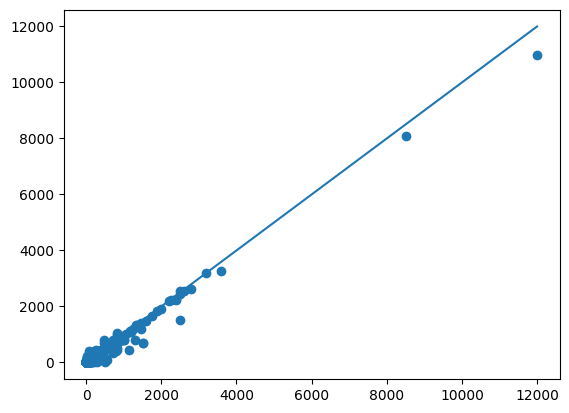

In [65]:
fig,ax = plt.subplots()
ax.scatter(norm_diff['true'],norm_diff['log_preds'])
_mx = max(norm_diff['true'])
print(_mx)
ax.plot((0,_mx),(0,_mx))
'';

3500.0


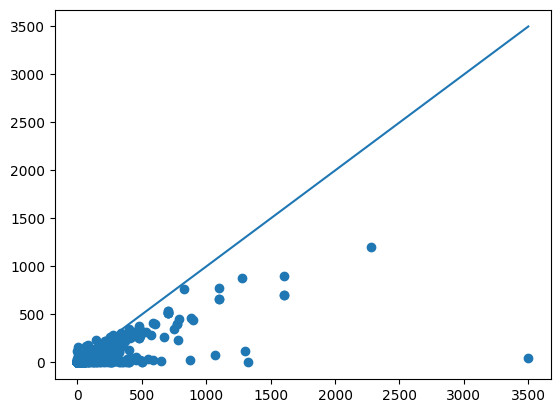

In [64]:
fig,ax = plt.subplots()
ax.scatter(foil_diff['true'],foil_diff['log_preds'])
_mx = max(foil_diff['true'])
print(_mx)
ax.plot((0,_mx),(0,_mx))
'';